In [1]:
%matplotlib inline
# %matplotlib widget

# Analysis of subjects

In [2]:
import csv
import os
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(rc={'figure.facecolor':'white'})

In [3]:
from demapper.code.utils.analyze import extract_dataset, plot_results, plot_limits
from demapper.code.utils.config_cme import ALL_DATASETS, FILTERS, get_plot_columns, extract_params_f



### Run for one dataset

In [5]:
PICKED_DATASET = 'cmev4euc'

datadir = ALL_DATASETS['ch8'][PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-averaged.csv')
results_path = os.path.join(datadir, 'compute_degrees_from_TCM/combined-compute_degrees_from_TCM.csv')

filter_by = FILTERS[PICKED_DATASET][0]
df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f, has_sbj=False)

resdir = datadir
if len(FILTERS[PICKED_DATASET]) > 1:
    resdir = os.path.join(datadir, filter_by)
    os.makedirs(resdir, exist_ok=True)

print(max_values)
df.sample(5)

len(stats):  539
len(results):  539
{}


,Mapper,K,R,G,ChangePointsIndicesError,ChangePointsCount,assortativity-mean,assortativity-std,coverage_TRs-mean,coverage_TRs-std,...,degree_TRs_avg-mean,degree_TRs_avg-std,degree_TRs_entropy-mean,degree_TRs_entropy-std,distances_entropy-mean,distances_entropy-std,distances_max-mean,distances_max-std,hrfdur_stat-mean,hrfdur_stat-std
219,EucNeuMapper_28_220_34,28,220,34,9.857143,8.0,-0.036726,0.048154,0.967825,0.038650,...,83.401378,37.156836,6.908817,0.507282,3.024135,0.494365,23.111111,11.390857,0.091280,0.039381
328,EucNeuMapper_36_260_50,36,260,50,8.571429,8.0,-0.064762,0.124836,0.999399,0.000962,...,1777.849444,451.534446,9.562615,0.163344,1.659228,0.331847,6.500000,2.007339,0.346187,0.067882
457,EucNeuMapper_48_180_34,48,180,34,10.714286,8.0,-0.084566,0.085587,0.990003,0.014266,...,208.012889,79.247691,8.103008,0.352344,2.236421,0.324564,11.944444,4.683792,0.138080,0.056013
227,EucNeuMapper_28_260_38,28,260,38,9.428571,8.0,-0.036798,0.060692,0.988747,0.015338,...,120.377011,28.677830,7.515664,0.367054,2.759768,0.489873,18.388889,8.374604,0.094544,0.028910
299,EucNeuMapper_36_100_46,36,100,46,5.857143,8.0,-0.042472,0.019234,0.999891,0.000318,...,2215.538889,393.982985,9.653462,0.077854,1.048827,0.202728,2.944444,0.416176,0.848275,0.100217


In [6]:

target_metrics = ['ChangePointsIndicesErrorRev', 'ChangePointsCount', 'coverage_nodes-mean', 'coverage_nodes-std', 'hrfdur_stat-mean', 'hrfdur_stat-std', 'distances_entropy-mean', 'distances_entropy-std']
log_metrics = ['ChangePointsIndicesErrorRev']

df['ChangePointsIndicesErrorRev'] = df.apply(
    lambda x: 1.0 / x['ChangePointsIndicesError'] if x['ChangePointsIndicesError'] > 0 else 100,
    axis=1)
# df['TransitionBetweenessRev'] = df.apply(lambda x: 1.0 / (x['TransitionBetweeness'] + 1), axis=1)


plot_results(df, 'SBJs_RKG', [], 'R', 'K', 'G', target_metrics, log_metrics, resdir=resdir)
plot_results(df, 'SBJs_KRG', [], 'K', 'R', 'G', target_metrics, log_metrics, resdir=resdir)

# for sbj_group_name, sbj_group in tqdm(sbjs_map.items()):
#     plot_results(df, sbj_group_name, sbj_group, fixedV, indexV, colV, target_metrics, log_metrics, resdir=resdir)
    

In [6]:
# Plot limits

target_metrics = {
    'ChangePointsIndicesError': [0, 12],
    'coverage_nodes-mean': [0.7, 1.0],
    'hrfdur_stat-mean': [0.15, 1.0],
    'distances_entropy-mean': [2.0, 10000.0]
}

fixedV, indexV, colV = get_plot_columns(filter_by)

plot_limits(df, 'SBJs_RKG', [], 'R', 'K', 'G', target_metrics, resdir=resdir)


## Recompute for all analysis that we have

In [8]:
# TYPE='degrees_TRs'
TYPE='compute_degrees_from_TCM'

target_metrics_detailed = ['ChangePointsIndicesErrorRev', 'ChangePointsCount', 'coverage_nodes-mean', 'coverage_nodes-std', 'hrfdur_stat-mean', 'hrfdur_stat-std', 'distances_entropy-mean', 'distances_entropy-std']
target_metrics = ['ChangePointsIndicesErrorRev', 'coverage_nodes-mean', 'hrfdur_stat-mean', 'distances_entropy-mean']
log_metrics = ['ChangePointsIndicesErrorRev']

target_metrics_limits = {
    'ChangePointsIndicesError': [0, 12],
    'coverage_nodes-mean': [0.7, 1.0],
    'hrfdur_stat-mean': [0.15, 1.0],
    'distances_entropy-mean': [2.0, 10000.0]
}
# CH = 'ch10'

# for CH in ['ch7', 'ch8', 'ch10', 'ch11']:
for CH in ['ch7', 'ch8', 'ch10', 'ch11']:
    for dataset_name in ALL_DATASETS[CH].keys():
#         if dataset_name not in ['cmev3_fast', 'cmev4_fast', 'cmev4euc_fast', 'cmev4euc', 'cmev5', 'cmev5MH']:
        if dataset_name not in ['cmev5MH']:
#         if not ('v3' in dataset_name or 'v4' in dataset_name):
            continue
        print('======= Processing', dataset_name)
        datadir = ALL_DATASETS[CH][dataset_name]
        print(datadir)
        break
        stats_path = os.path.join(datadir, 'compute_stats-averaged.csv')
    #     results_path = os.path.join(datadir, 'compute_degrees_from_TCM/combined-compute_degrees_from_TCM.csv')
        results_path = os.path.join(datadir, '{0}/combined-{0}.csv'.format(TYPE))

        try:
            for filter_by in FILTERS[dataset_name]:
                resdir = datadir
                if len(FILTERS[dataset_name]) > 1:
                    resdir = os.path.join(datadir, filter_by)
                    os.makedirs(resdir, exist_ok=True)
                df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f, has_sbj=False)

                fixedV, indexV, colV = get_plot_columns(filter_by)
                df['ChangePointsIndicesErrorRev'] = df.apply(lambda x: 1.0 / x['ChangePointsIndicesError'] if x['ChangePointsIndicesError'] > 0 else 10, axis=1)

                plot_results(df, 'SBJs-{}'.format(TYPE), [], fixedV, indexV, colV, target_metrics, log_metrics, resdir=resdir)
                plot_results(df, 'SBJs-{}_detailed'.format(TYPE), [], fixedV, indexV, colV, target_metrics_detailed, log_metrics, resdir=resdir)
                plot_limits(df, 'SBJs-{}'.format(TYPE), [], fixedV, indexV, colV, target_metrics_limits, resdir=resdir)
        except Exception as err:
            print("Warning! Didn't process '{}' because:".format(dataset_name))
            print(err)
            raise err

======= Processing cmev5MH
/Users/dh/workspace/BDL/demapper/results/cme/ch7_mappers_cmev5MH.json
======= Processing cmev5MH
/Users/dh/workspace/BDL/demapper/results/cme/ch8_mappers_cmev5MH.json
======= Processing cmev5MH
/Users/dh/workspace/BDL/demapper/results/cme/ch10_mappers_cmev5MH.json
======= Processing cmev5MH
/Users/dh/workspace/BDL/demapper/results/cme/ch11_mappers_cmev5MH.json


## Analysis for one subject on modularity

In [17]:
PICKED_DATASET = 'cmev4euc'
CH = 'ch8'

datadir = ALL_DATASETS[CH][PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-averaged.csv')
results_path = os.path.join(datadir, 'modularity-avg.csv')

filter_by = FILTERS[PICKED_DATASET][0]
df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f, has_sbj=False)

resdir = datadir
if len(FILTERS[PICKED_DATASET]) > 1:
    resdir = os.path.join(datadir, filter_by)
    os.makedirs(resdir, exist_ok=True)

print(max_values)
df.sample(5)

len(stats):  539
len(results):  539
{}


,Mapper,K,R,G,NrNodes-mean,NrNodes-std,CalModNodes-mean,CalModNodes-std,CalModTRs-mean,CalModTRs-std,...,degree_TRs_avg-mean,degree_TRs_avg-std,degree_TRs_entropy-mean,degree_TRs_entropy-std,distances_entropy-mean,distances_entropy-std,distances_max-mean,distances_max-std,hrfdur_stat-mean,hrfdur_stat-std
351,EucNeuMapper_40_140_30,40,140,30,391.722222,122.720536,0.240743,0.081256,0.007412,0.011374,...,146.774900,32.379793,7.765472,0.318248,2.296674,0.381649,11.722222,4.599304,0.180667,0.054694
373,EucNeuMapper_40_260_34,40,260,34,836.777778,146.592896,0.467271,0.076225,0.052367,0.055771,...,76.759400,18.841842,7.081464,0.349147,2.780774,0.380284,18.777778,6.629307,0.054579,0.020121
41,EucNeuMapper_12_300_50,12,300,50,678.833333,135.417112,0.354055,0.093189,0.038287,0.030604,...,215.320944,66.766407,7.989669,0.373724,2.505363,0.481377,14.166667,6.564163,0.264192,0.061511
16,EucNeuMapper_12_180_34,12,180,34,396.000000,88.364220,0.326581,0.073557,0.038635,0.025896,...,92.856761,21.816130,7.163037,0.375157,2.595409,0.438002,14.166667,5.992643,0.313415,0.062305
210,EucNeuMapper_28_180_26,28,180,26,334.777778,94.513961,0.444863,0.133762,0.105098,0.065392,...,15.763083,6.099674,4.894934,0.492435,3.267808,0.397841,20.555556,5.659165,0.046603,0.023959


In [18]:
df.columns

Index(['Mapper', 'K', 'R', 'G', 'NrNodes-mean', 'NrNodes-std',
       'CalModNodes-mean', 'CalModNodes-std', 'CalModTRs-mean',
       'CalModTRs-std', 'assortativity-mean', 'assortativity-std',
       'coverage_TRs-mean', 'coverage_TRs-std', 'coverage_nodes-mean',
       'coverage_nodes-std', 'degree_TRs_avg-mean', 'degree_TRs_avg-std',
       'degree_TRs_entropy-mean', 'degree_TRs_entropy-std',
       'distances_entropy-mean', 'distances_entropy-std', 'distances_max-mean',
       'distances_max-std', 'hrfdur_stat-mean', 'hrfdur_stat-std'],
      dtype='object')

In [22]:
target_metrics = ['NrNodes-mean', 'NrNodes-std', 'CalModNodes-mean', 'CalModNodes-std',
                  'CalModTRs-mean', 'CalModTRs-std', 'coverage_nodes-mean', 'coverage_nodes-std',
                  'hrfdur_stat-mean', 'hrfdur_stat-std', 'distances_entropy-mean', 'distances_entropy-std']

plot_results(df, 'mod_SBJs', [], 'R', 'K', 'G', target_metrics, [], resdir=resdir)


## Compute modularity plots for all 

In [41]:
# TYPE='degrees_TRs'
# TYPE='compute_degrees_from_TCM'

target_metrics_detailed = ['NrNodes-mean', 'NrNodes-std', 'CalModNodes-mean', 'CalModNodes-std',
                  'CalModTRs-mean', 'CalModTRs-std', 'coverage_nodes-mean', 'coverage_nodes-std',
                  'hrfdur_stat-mean', 'hrfdur_stat-std', 'distances_entropy-mean', 'distances_entropy-std']
target_metrics = ['NrNodes-mean', 'CalModNodes-mean', 'CalModTRs-mean', 'coverage_nodes-mean', 
                  'hrfdur_stat-mean', 'distances_entropy-mean']
log_metrics = [] # ['NrNodes-mean']

target_metrics_limits = {
#     'ChangePointsIndicesError': [0, 12],
    'coverage_nodes-mean': [0.7, 1.0],
    'hrfdur_stat-mean': [0.15, 1.0],
    'distances_entropy-mean': [2.0, 10000.0]
}
CH = 'ch8'

for dataset_name in ALL_DATASETS[CH].keys():
#     if dataset_name not in ['cmev3', 'cmev4euc']:
#         continue
    if not ('v3' in dataset_name or 'v4' in dataset_name):
        continue
    print('======= Processing', dataset_name)
    datadir = ALL_DATASETS[CH][dataset_name]
    stats_path = os.path.join(datadir, 'compute_stats-averaged.csv')
    results_path = os.path.join(datadir, 'modularity-avg.csv')

    try:
        for filter_by in FILTERS[dataset_name]:
            resdir = datadir
            if len(FILTERS[dataset_name]) > 1:
                resdir = os.path.join(datadir, filter_by)
                os.makedirs(resdir, exist_ok=True)
            df, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f, has_sbj=False)

            fixedV, indexV, colV = get_plot_columns(filter_by)
            plot_results(df, 'mod_SBJs-{}'.format(TYPE), [], fixedV, indexV, colV, target_metrics, log_metrics, resdir=resdir)
            plot_results(df, 'mod_SBJs-{}_detailed'.format(TYPE), [], fixedV, indexV, colV, target_metrics_detailed, log_metrics, resdir=resdir)
#             plot_limits(df, 'SBJs-{}'.format(TYPE), [], fixedV, indexV, colV, target_metrics_limits, resdir=resdir)
    except Exception as err:
        print("Warning! Didn't process '{}' because:".format(dataset_name))
        print(err)
        raise err

======= Processing cmev3
len(stats):  462
len(results):  462
======= Processing cmev4
len(stats):  539
len(results):  539
======= Processing cmev4euc
len(stats):  539
len(results):  539
======= Processing cmev3_fast
len(stats):  640
len(results):  640
======= Processing cmev4_fast
len(stats):  900
len(results):  900
======= Processing cmev4euc_fast
len(stats):  900
len(results):  900


## K-values plot

In [4]:
def filter_dataframe(df, filters):
    df_filter = None
    for fi, (key, vals) in enumerate(filters.items()):
        df_f = df[key] == vals[0]
        for i in range(1, len(vals)):
            df_f = (df_f | (df[key] == vals[i]))
        if fi == 0:
            df_filter = df_f
        else:
            df_filter = (df_f & df_filter)
        
    df_filtered = df[df_filter]
    return df_filtered

def count_passing(df, limits):
    df_filter = None
    for fi, (target, lims) in enumerate(limits.items()):
        df_f = (df[target] >= lims[0]) & (df[target] <= lims[1]) 
        if fi == 0:
            df_filter = df_f
        else:
            df_filter = (df_f & df_filter)
    return(sum(df_filter))


In [5]:


def plot_kvals_plot(datadir, TYPE, filter_by, dists, ChangePointsError_limit):
    target_metrics_limits = {
        'ChangePointsIndicesError': [0, ChangePointsError_limit],
        'coverage_nodes-mean': [0.7, 1.0],
        'hrfdur_stat-mean': [0.15, 1.0],
        'distances_entropy-mean': [2.0, 10000.0]
    }

    stats_path = os.path.join(datadir, 'compute_stats-averaged.csv')
    results_path = os.path.join(datadir, '{0}/combined-{0}.csv'.format(TYPE))

    # Extract geodesic distances mappers
    df_geo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f, has_sbj=False)

    Kvals = sorted(df_geo['K'].drop_duplicates().to_numpy())

    table = []
    # counts = {d:{} for d in dists}
    for dist in dists:
        for k in Kvals:
            fdf = filter_dataframe(df_geo, { 'dist': [dist], 'K': [k] })
            cnt = count_passing(fdf, target_metrics_limits)
            table.append({
                'Distance type': dist,
                'K': k,
                'count': cnt,
                'perc': cnt / len(fdf) * 100.0,
                'len': len(fdf),
            })

    counts_df = pd.DataFrame(data=table)

    f, ax = plt.subplots(figsize=(10, 5))
    # ax.set(xscale="log")

    g = sns.lineplot(data=counts_df, x="K", y="perc", hue="Distance type", style="Distance type", markers=True, dashes=False)
    g.set(xscale="log")
    g.set_ylabel("Percentage valid")
    g.set_xticks(sorted(Kvals))
    g.set_xticklabels(sorted(Kvals))
    g.set(ylim=(0, 100))
    plt.tight_layout()
#     plt.show()

    save_path = os.path.join(datadir, 'kvalue_dists_distrib_{}_err{}.png'.format(filter_by, ChangePointsError_limit))
    plt.savefig(save_path, dpi=150)
    print('Saved at: ', save_path)
    plt.close()
    
    return df_geo, counts_df

def plot_non_geo_dists(datadir, TYPE, filter_by, dists, ChangePointsError_limit):
    stats_path = os.path.join(datadir, 'compute_stats-averaged.csv')
    results_path = os.path.join(datadir, '{0}/combined-{0}.csv'.format(TYPE))
    # Extract geodesic distances mappers
    df_nongeo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f, has_sbj=False)

    target_metrics_limits = {
        'ChangePointsIndicesError': [0, ChangePointsError_limit],
        'coverage_nodes-mean': [0.7, 1.0],
        'hrfdur_stat-mean': [0.15, 1.0],
        'distances_entropy-mean': [2.0, 10000.0]
    }

    table = []
    # counts = {d:{} for d in dists}
    for dist in dists:
        fdf = filter_dataframe(df_nongeo, { 'dist': [dist] })
        cnt = count_passing(fdf, target_metrics_limits)
        table.append({
            'Distance type': dist,
            'K': 'non geodesic',
            'count': cnt,
            'perc': cnt / len(fdf) * 100.0,
            'len': len(fdf),
        })

    counts_df = pd.DataFrame(data=table)

    g = sns.catplot(
        data=counts_df, kind="bar",
        x="Distance type", y="perc",
        ci="sd", palette="dark", alpha=.7, height=6, aspect=0.5
    )
    g.despine(left=True)
    g.set_axis_labels("", "Percentage valid")
    g.set(ylim=(0, 100))
    g.set_xticklabels(rotation=70)
    plt.tight_layout()
#     plt.show()

    save_path = os.path.join(datadir, 'nongeo_dists_{}_distrib.png'.format(filter_by))
    plt.savefig(save_path, dpi=150)
    print('Saved at', save_path)
    plt.close()
    
    return df_nongeo, counts_df



def plot_results_for_geo(df_geo, dists, resdir):
    # Print the results of all metrics
    target_metrics_detailed = ['ChangePointsIndicesErrorRev', 'ChangePointsCount', 'coverage_nodes-mean', 'coverage_nodes-std', 'hrfdur_stat-mean', 'hrfdur_stat-std', 'distances_entropy-mean', 'distances_entropy-std']
    target_metrics = ['ChangePointsIndicesErrorRev', 'coverage_nodes-mean', 'hrfdur_stat-mean', 'distances_entropy-mean']
    log_metrics = ['ChangePointsIndicesErrorRev']

    df_geo['ChangePointsIndicesErrorRev'] = df_geo.apply(lambda x: 1.0 / x['ChangePointsIndicesError'] if x['ChangePointsIndicesError'] > 0 else 10, axis=1)

    for dist in tqdm(dists):
        df = df_geo[df_geo['dist'] == dist]
        plot_results(df, '{}_{}-{}'.format(filter_by, dist, TYPE), [], 'R', 'K', 'G', target_metrics, log_metrics, resdir=resdir)
        plot_results(df, '{}_{}-{}_detailed'.format(filter_by, dist, TYPE), [], 'R', 'K', 'G', target_metrics_detailed, log_metrics, resdir=resdir)
        # plot_limits(df, 'SBJs-{}'.format(TYPE), [], fixedV, indexV, colV, target_metrics_limits, resdir=resdir)



In [6]:
 
PICKED_DATASET = 'cmev7kval'
dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']
TYPE='compute_degrees_from_TCM'
ChangePointsError_limit = 12
CH = 'ch10'

datadir = ALL_DATASETS[CH][PICKED_DATASET]

filter_by = FILTERS[PICKED_DATASET][0]
df_geo, counts_df = plot_kvals_plot(datadir, TYPE, filter_by, dists, ChangePointsError_limit)
plot_results_for_geo(df_geo, dists, datadir)

# plot_non_geo_dists(datadir, TYPE, FILTERS[PICKED_DATASET][1], dists, ChangePointsError_limit)

len(stats):  2000
len(results):  2000
Saved at:  /Users/dh/workspace/BDL/demapper/results/cme/ch10_mappers_cmev7kval_fast.json/kvalue_dists_distrib_DistsGeoNeuMapper_err12.png


100%|████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:43<00:00, 20.73s/it]


In [18]:
 
PICKED_DATASET = 'cmev6kval'
dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']
TYPE='compute_degrees_from_TCM'
ChangePointsError_limit = 12
CH = 'ch7'

datadir = ALL_DATASETS[CH][PICKED_DATASET]

for filter_by in [FILTERS[PICKED_DATASET][0], FILTERS[PICKED_DATASET][2]]:
    df_geo, counts_df = plot_kvals_plot(datadir, TYPE, filter_by, dists, ChangePointsError_limit)
    plot_results_for_geo(df_geo, dists, datadir)

plot_non_geo_dists(datadir, TYPE, FILTERS[PICKED_DATASET][1], dists, ChangePointsError_limit)

len(stats):  4125
len(results):  4125
Saved at:  /Users/dh/workspace/BDL/demapper/results/cme/ch7_mappers_cmev6kval_fast.json/kvalue_dists_distrib_DistsGeoBDLMapper_err12.png


100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [01:47<00:00, 21.48s/it]


len(stats):  4125
len(results):  4125
Saved at:  /Users/dh/workspace/BDL/demapper/results/cme/ch7_mappers_cmev6kval_fast.json/kvalue_dists_distrib_DistsGeoNeuMapper_err12.png


100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [01:48<00:00, 21.70s/it]

len(stats):  4125
len(results):  4125
Saved at /Users/dh/workspace/BDL/demapper/results/cme/ch7_mappers_cmev6kval_fast.json/nongeo_dists_DistsBDLMapper_distrib.png


In [83]:
PICKED_DATASET = 'cmev6kval'
# dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']
dists = ['correlation', 'cosine', 'euclidean', 'cityblock', 'chebychev']
TYPE='compute_degrees_from_TCM'
ChangePointsError_limit = 12
CH = 'ch10'

datadir = ALL_DATASETS[CH][PICKED_DATASET]

filter_by = FILTERS[PICKED_DATASET][0]
df_geo, counts_geo_df = plot_kvals_plot(datadir, TYPE, filter_by, dists, ChangePointsError_limit)
df_nongeo, counts_nongeo_df = plot_non_geo_dists(datadir, TYPE, FILTERS[PICKED_DATASET][1], dists, ChangePointsError_limit)

counts_geo_df['K'] = counts_geo_df.apply(lambda x: 'geodesic k='+str(x['K']), axis=1)
counts_df = pd.concat([counts_nongeo_df, counts_geo_df])
counts_df = filter_dataframe(counts_df, {'K': ['non geodesic'] + ['geodesic k={}'.format(k) for k in [6, 8, 12, 24, 32]]})


len(stats):  4125
len(results):  4125
Saved at:  /Users/dh/workspace/BDL/demapper/results/cme/ch10_mappers_cmev6kval_fast.json/kvalue_dists_distrib_DistsGeoBDLMapper_err12.png
len(stats):  4125
len(results):  4125
Saved at /Users/dh/workspace/BDL/demapper/results/cme/ch10_mappers_cmev6kval_fast.json/nongeo_dists_DistsBDLMapper_distrib.png


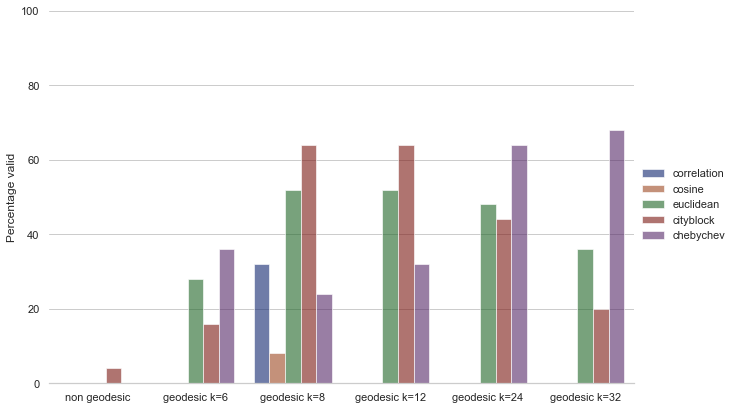

In [85]:
sns.set(style = "whitegrid")
g = sns.catplot(
    data=counts_df, kind="bar",
    x="K", y="perc", hue="Distance type",
    ci="sd", palette="dark", alpha=.6, 
    height=6, aspect=9/6
)
g.despine(left=True)
g.set_axis_labels("", "Percentage valid")
g.set(ylim=(0, 100))
g.legend.set_title("")
plt.show()

In [40]:
counts_df[counts_df['K'] == 8]

,Distance type,K,count,perc,len
3,chebychev,8,6,24.0,25
19,correlation,8,0,0.0,25
35,cosine,8,0,0.0,25
51,cityblock,8,9,36.0,25
67,euclidean,8,12,48.0,25


In [56]:

counts_geo_df

,Distance type,K,count,perc,len,K-full
0,correlation,geodesic k=3,0,0.0,25,geodesic k=3
1,correlation,geodesic k=4,3,12.0,25,geodesic k=4
2,correlation,geodesic k=6,0,0.0,25,geodesic k=6
3,correlation,geodesic k=8,8,32.0,25,geodesic k=8
4,correlation,geodesic k=12,0,0.0,25,geodesic k=12
...,...,...,...,...,...,...
75,chebychev,geodesic k=128,13,52.0,25,geodesic k=128
76,chebychev,geodesic k=256,8,32.0,25,geodesic k=256
77,chebychev,geodesic k=384,4,16.0,25,geodesic k=384
78,chebychev,geodesic k=512,1,4.0,25,geodesic k=512


In [20]:

### Non-geodesic distribution
dists = ['chebychev', 'correlation', 'cosine', 'cityblock', 'euclidean']

PICKED_DATASET = 'ss_w3cv5lens2_fast'
datadir = DATASETS[PICKED_DATASET]
stats_path = os.path.join(datadir, 'compute_stats-combined.csv')
results_path = os.path.join(datadir, 'scores-all.csv')

# Extract non-geodesic distances mappers
filter_by = FILTERS[PICKED_DATASET][1]
df_nongeo, max_values = extract_dataset(stats_path, results_path, filter_by, extract_params_f)
target_metrics_limits_nongeo = {
    'TransitionBetweeness': [0, max_values['TransitionBetweeness'] * 0.99], # Need the data first, add later
    'coverage_nodes': [0.7, 1.0],
    'distances_entropy': [2.0, 10000.0],
    'hrfdur_stat': [0.15, 1.0],
}

# sbjs = df_geo['SBJ'].drop_duplicates().to_numpy()
# for sbj in tqdm(sbjs):
    
sbj = 'SBJ99'
sbj_filters = {
    'SBJ': [sbj],
}

df_nongeodists = filter_dataframe(df_nongeo, sbj_filters)

table = []
table = []
for dist in dists:
    fdf = filter_dataframe(df_nongeodists, { 'dist': [dist] })
    cnt = count_passing(fdf, target_metrics_limits_nongeo)
    table.append({
        'dist': dist,
        'K': 'non geodesic',
        'count': cnt,
        'perc': cnt / len(fdf) * 100.0,

    })


counts_df = pd.DataFrame(data=table)

g = sns.catplot(
    data=counts_df, kind="bar",
    x="dist", y="perc",
    ci="sd", palette="dark", alpha=.7, height=6, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("", "Percentage valid")
g.set(ylim=(0, 100))
g.set_xticklabels(rotation=70)
plt.tight_layout()
plt.show()

# save_path = os.path.join(datadir, 'nongeo_dists_{}_distrib.png'.format(sbj))
# plt.savefig(save_path, dpi=150)
# plt.close()


NameError: name 'DATASETS' is not defined